
# MNIST MLP with BatchNorm and Dropout
Training a simple fully connected network on MNIST with torchvision data, then plotting performance. Comments explain each step and parameter.


In [13]:

import torch  # core tensor library and autograd
from torch import nn  # neural network layers and losses
from torch.utils.data import DataLoader  # mini-batch loader utility
from torchvision import datasets, transforms  # datasets and preprocessing
import matplotlib.pyplot as plt  # plotting
import numpy as np  # numerical helpers
from pathlib import Path  # filesystem paths

torch.manual_seed(42)  # deterministic init for reproducibility
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # pick GPU when available
print(f"Using device: {DEVICE}")  # confirm device choice


Using device: cpu


In [14]:

data_root = Path("data")  # root directory where MNIST will be stored
transform = transforms.Compose([
    transforms.ToTensor(),  # convert PIL image to torch tensor in [0,1]
    transforms.Normalize((0.1307,), (0.3081,)),  # standard MNIST mean/std per channel
])

train_dataset = datasets.MNIST(
    root=data_root,  # download location
    train=True,  # training split
    download=True,  # fetch if missing
    transform=transform,  # preprocessing pipeline
)
test_dataset = datasets.MNIST(
    root=data_root,
    train=False,  # test split
    download=True,
    transform=transform,
)

batch_size = 128  # samples per mini-batch
num_workers = 2  # dataloader worker processes
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # shuffle training data each epoch
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),  # faster host->GPU transfer
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # keep order for evaluation
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

class_names = [str(i) for i in range(10)]  # label names for 0-9
print(f"Train samples: {len(train_dataset):,}")
print(f"Test samples:  {len(test_dataset):,}")


Train samples: 60,000
Test samples:  10,000


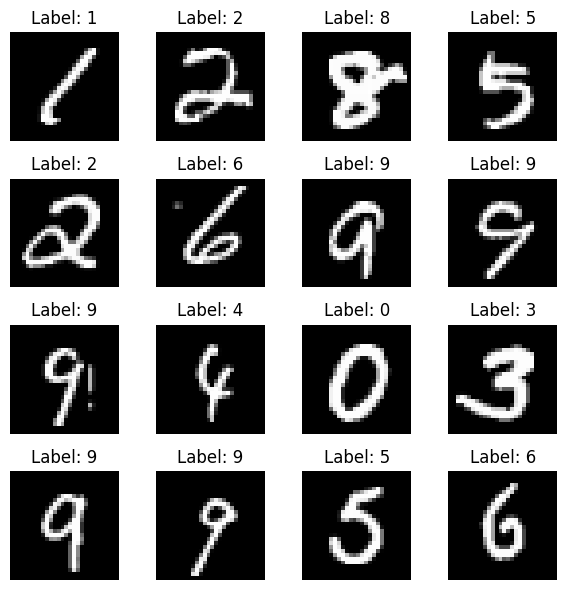

In [ ]:
def add(a: int, b: int) -> int:
    return a + b

def show_batch(data_loader, n=16):
    images, labels = next(iter(data_loader))  # grab one batch
    images = images[:n]  # first n images
    labels = labels[:n]  # first n labels
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))  # grid for 16 samples
    for idx, ax in enumerate(axes.flat):
        ax.imshow(images[idx].squeeze(), cmap="gray")  # display grayscale
        ax.set_title(f"Label: {labels[idx].item()}")  # annotate true label
        ax.axis("off")  # hide axes
    plt.tight_layout()

show_batch(train_loader)  # visualize training samples


In [ ]:

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        


    def forward(self, x):
        return self.model(x)  # run through the stack

model = MLP().to(DEVICE)  # move to GPU or CPU
print(model)  # architecture summary


MLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [17]:

def accuracy(logits, labels):
    preds = logits.argmax(dim=1)  # predicted class per sample
    return (preds == labels).float().mean().item()  # mean accuracy as float

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()  # enable dropout/batchnorm training mode
    running_loss = 0.0
    running_acc = 0.0
    total = 0
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # move batch to device

        optimizer.zero_grad()  # reset gradients
        logits = model(images)  # forward pass
        loss = criterion(logits, labels)  # compute loss
        loss.backward()  # backpropagate
        optimizer.step()  # update weights

        batch_size = labels.size(0)  # number of samples this batch
        running_loss += loss.item() * batch_size  # accumulate summed loss
        running_acc += accuracy(logits, labels) * batch_size  # accumulate summed accuracy
        total += batch_size  # track sample count

    return running_loss / total, running_acc / total  # average metrics

def evaluate(model, loader, criterion):
    model.eval()  # eval mode disables dropout, uses running stats
    running_loss = 0.0
    running_acc = 0.0
    total = 0
    with torch.no_grad():  # no gradients during evaluation
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            logits = model(images)
            loss = criterion(logits, labels)

            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            running_acc += accuracy(logits, labels) * batch_size
            total += batch_size

    return running_loss / total, running_acc / total


In [18]:

epochs = 8  # training epochs
learning_rate = 1e-3  # Adam step size

criterion = nn.CrossEntropyLoss()  # multi-class classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # optimizer over all params

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}  # store metrics per epoch

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch + 1}/{epochs} - "
        f"train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, "
        f"val loss: {val_loss:.4f}, val acc: {val_acc:.4f}"
    )


Epoch 1/8 - train loss: 0.2878, train acc: 0.9223, val loss: 0.1118, val acc: 0.9663
Epoch 2/8 - train loss: 0.1212, train acc: 0.9633, val loss: 0.0816, val acc: 0.9747
Epoch 3/8 - train loss: 0.0902, train acc: 0.9720, val loss: 0.0706, val acc: 0.9786
Epoch 4/8 - train loss: 0.0762, train acc: 0.9763, val loss: 0.0656, val acc: 0.9787
Epoch 5/8 - train loss: 0.0657, train acc: 0.9786, val loss: 0.0612, val acc: 0.9813
Epoch 6/8 - train loss: 0.0563, train acc: 0.9821, val loss: 0.0572, val acc: 0.9822
Epoch 7/8 - train loss: 0.0509, train acc: 0.9836, val loss: 0.0578, val acc: 0.9827
Epoch 8/8 - train loss: 0.0454, train acc: 0.9851, val loss: 0.0595, val acc: 0.9809


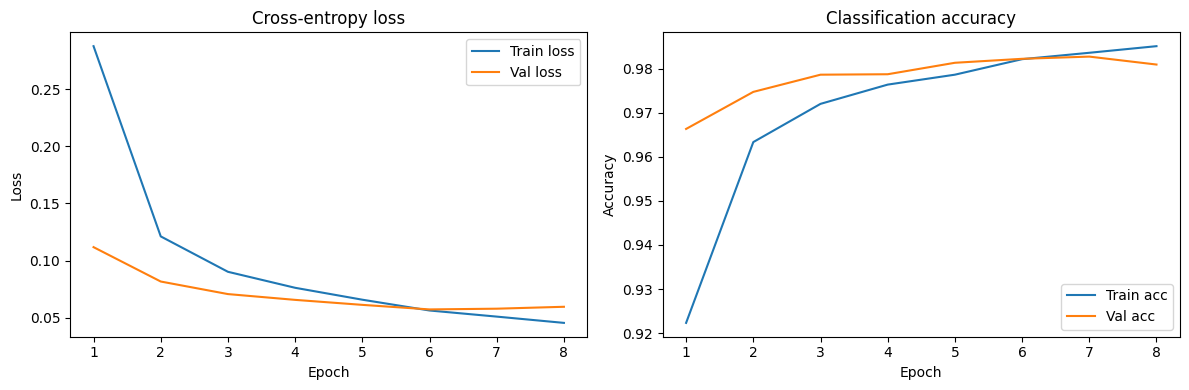

In [19]:

epochs_range = range(1, epochs + 1)  # x-axis for plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # side-by-side plots

axes[0].plot(epochs_range, history["train_loss"], label="Train loss")
axes[0].plot(epochs_range, history["val_loss"], label="Val loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].set_title("Cross-entropy loss")

axes[1].plot(epochs_range, history["train_acc"], label="Train acc")
axes[1].plot(epochs_range, history["val_acc"], label="Val acc")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].set_title("Classification accuracy")

plt.tight_layout()
plt.show()
